<a href="https://colab.research.google.com/github/kaz2ngt/colaboratory/blob/master/11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前準備: ドライブのマウントとデータの取得

In [0]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 下記でdriveからコピーして解凍
!cp drive/My\ Drive/Colab\ Notebooks/11img.zip ./
!unzip 11img.zip

# リストPART2

In [0]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

# 11_1: ResidualBlockを作成する関数の定義

In [0]:
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Add, Activation

def residual_block(input_ts):
  """ResidualBlockの構築する関数"""
  x = Conv2D(
    128, (3, 3), strides=1, padding='same'
  )(input_ts)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  return Add()([x, input_ts])

# 11_2: 変換ネットワークを構築するencoder・decoder関数の定義

In [0]:
from tensorflow.python.keras.layers import Input, Lambda, Conv2DTranspose
from tensorflow.python.keras.models import Model

def build_encoder_decoder(input_shape=(224, 224, 3)):
  """変換用ネットワークの構築"""
  
  # Encoder部分
  input_ts = Input(shape=input_shape, name='input')
  
  # 入力を [0, 1] の範囲に正規化
  x = Lambda(lambda a: a/255.)(input_ts)
  
  x = Conv2D(32, (9, 9), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # ResidualBlockを5ブロック追加
  for _ in range(5):
    x = residual_block(x)

  # Decoder部分
  x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(3, (9, 9), strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)

  # 出力値が [0, 255] になるようにスケール変換
  gen_out = Lambda(lambda a: (a + 1)*127.5)(x)
  
  model_gen = Model(
      inputs=[input_ts],
      outputs=[gen_out]
  )
  
  
  return model_gen

input_shape = (224, 224, 3)

# 変換ネットワークの構築
model_gen = build_encoder_decoder(
    input_shape=input_shape
)

W0813 03:01:13.987965 140528444229504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# 11_3: 学習用ネットワークの構築

In [0]:
from tensorflow.python.keras.applications.vgg16 import VGG16

# 学習済みモデルVGG16の呼び出し
vgg16 = VGG16()

# 重みパラメータを学習させない設定をする
for layer in vgg16.layers:
  layer.trainable = False

# VGG16のための入力値を前処理する関数
def norm_vgg16(x):
  """RGB->BGR変換と近似的に中心化を行う関数"""
  return (x[:, :, :, ::-1] - 120)/255.

# 特徴量を抽出する層の名前を定義
style_layer_names = (
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
)
contents_layer_names = ('block3_conv3', )

# 中間層の出力を保持するためのスクリプト
style_outputs_gen = []
contents_outputs_gen = []

input_gen = model_gen.output # 変換ネットワークの出力を入力とする
z = Lambda(norm_vgg16)(input_gen) # 入力値の正規化
for layer in vgg16.layers:
  z = layer(z) # VGG16の層を積み上げてネットワークを構築
  if layer.name in style_layer_names:
    # スタイル特徴量抽出用の中間層の出力を追加
    style_outputs_gen.append(z)
  if layer.name in contents_layer_names:
    # コンテンツ特徴量抽出用の中間層の出力を追加
    contents_outputs_gen.append(z)

# モデルを定義
model = Model(
    inputs=model_gen.input,
    outputs=style_outputs_gen + contents_outputs_gen
)

553467904/553467096 [==============================] - 17s 0us/step


# 11_4:  スタイルの手本となる画像の読み込み

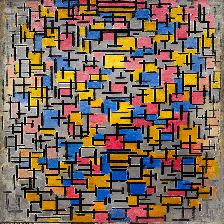

In [0]:
input_size = input_shape[:2]

# スタイル画像の読み込み
img_sty = load_img(
    'img/style/Piet_Mondrian_Composition.png',
    target_size=input_size
)

# スタイル画像の表示
img_sty

# 11_5: スタイルの手本となる画像をnumpy.ndarrayに変換

In [0]:
# 読み込んだ画像をnumpy.ndarrayに変換
img_arr_sty = np.expand_dims(img_to_array(img_sty), axis=0)

# 11_6: 手本となる画像のスタイル特徴量の抽出

In [0]:
# 入力層の定義
input_sty = Input(shape=input_shape, name='input_sty')

style_outputs = [] # 中間層の出力を保持するリスト
x = Lambda(norm_vgg16)(input_sty)
for layer in  vgg16.layers:
  x = layer(x)
  if layer.name in style_layer_names:
    style_outputs.append(x)

# スタイルの手本となる画像を入力して、特徴量を出力するモデルを定義
model_sty = Model(
    inputs=input_sty,
    outputs=style_outputs
)

# 手本画像から正解データとなる特徴量を抽出
y_true_sty = model_sty.predict(img_arr_sty)

# 11_7: 手本となる画像のコンテンツ特徴量の抽出用ネットワーク構築

In [0]:
# 入力層の定義
input_con = Input(shape=input_shape, name='input_con')

contents_outputs = [] # 中間層の出力を保持するリスト
y = Lambda(norm_vgg16)(input_con)
for layer in vgg16.layers:
  y = layer(y)
  if layer.name in contents_layer_names:
    contents_outputs.append(y)

# コンテンツの手本画像を入力して、特徴量を出力するモデルを定義
model_con = Model(
    inputs=input_con,
    outputs=contents_outputs
)

# 11_8: 画像読み込み用の関数定義

In [0]:
# 画像ファイル読み込み用のラッパー関数定義
def load_imgs(img_paths, target_size=(224, 224)):
  """画像ファイルのパスのリストから、配列のバッチを返す"""
  _load_img = lambda x: img_to_array(
      load_img(x, target_size=target_size)
  )
  img_list = [
      np.expand_dims(_load_img(img_path), axis=0)
      for img_path  in img_paths
  ]
  return np.concatenate(img_list, axis=0)

# 11_9: ジェネレータ用の関数定義

In [0]:
import math

def train_generator(img_paths, batch_size, model, y_true_sty, shuffle=True, epochs=None):
  """学習データを生成するジェネレータ"""
  n_samples = len(img_paths)
  indices = list(range(n_samples))
  steps_per_epoch = math.ceil(n_samples / batch_size)
  img_paths = np.array(img_paths)
  cnt_epoch = 0
  while True:
    cnt_epoch += 1
    if shuffle:
      np.random.shuffle(indices)
    for i in range(steps_per_epoch):
      start = batch_size*i
      end = batch_size*(i + 1)
      X = load_imgs(img_paths[indices[start:end]])
      batch_size_act = X.shape[0]
      y_true_sty_t = [
          np.repeat(feat, batch_size_act, axis=0)
          for feat in y_true_sty
      ]
      # コンテンツ特徴量の抽出
      y_true_con = model.predict(X)
      yield (X, y_true_sty_t + [y_true_con])
    if epochs is not None:
      if cnt_epoch >= epochs:
        raise StopIteration

# 11_10: ジェネレータの生成

In [0]:
import glob

# 入力画像ファイルのパスを取得
path_glob = os.path.join('img/context/*.jpg')
img_paths = glob.glob(path_glob)

# バッチサイズとエポック数の設定
batch_size = 2
epochs = 10

# ジェネレータを生成
gen = train_generator(
    img_paths,
    batch_size,
    model_con,
    y_true_sty,
    epochs=epochs
)

# 11_11: コンテンツ特徴量の損失関数

In [0]:
from tensorflow.python.keras import backend as K

def feature_loss(y_true, y_pred):
  """コンテンツ特徴量の損失関数"""
  norm = K.prod(K.cast(K.shape(y_true)[1:], 'float32'))
  return K.sum(
      K.square(y_pred - y_true), axis=(1,2,3)
  )/norm

# 11_12: スタイル特徴量の損失関数

In [0]:
def gram_matrix(X):
  """グラム行列の算出"""
  X_sw = K.permute_dimensions(
      X, (0, 3, 2, 1)
  ) # 軸の入れ替え
  s = K.shape(X_sw)
  new_shape = (s[0], s[1], s[2]*s[3])
  X_rs = K.reshape(X_sw, new_shape)
  X_rs_t = K.permute_dimensions(
      X_rs, (0, 2, 1)
  ) # 行列の転置
  dot = K.batch_dot(X_rs, X_rs_t) # 内積の計算
  norm = K.prod(K.cast(s[1:], 'float32'))
  return dot/norm

def style_loss(y_true, y_pred):
  """スタイル用の損失関数定義"""
  return K.sum(
      K.square(
          gram_matrix(y_pred) - gram_matrix(y_true)
      ),
      axis=(1, 2)
  )

# 11_13: モデルや結果を保存するディレクトリの準備

In [0]:
import datetime

# モデルや結果を保存するディレクトリの準備
dt = datetime.datetime.now()
dir_log = 'model/{:%y%m%d_%H%M%S}'.format(dt)
dir_weights = 'model/{:%y%m%d_%H%M%S}/weights'.format(dt)
dir_trans = 'model/{:%y%m%d_%H%M%S}/img_trans'.format(dt)

os.makedirs(dir_log, exist_ok=True)
os.makedirs(dir_weights, exist_ok=True)
os.makedirs(dir_trans, exist_ok=True)

# 11_14: モデルのコンパイル

In [0]:
from tensorflow.python.keras.optimizers import Adadelta

# モデルのコンパイル
model.compile(
    optimizer=Adadelta(),
    loss=[
        style_loss,
        style_loss,
        style_loss,
        style_loss,
        feature_loss
    ],
    loss_weights=[1.0, 1.0, 1.0, 1.0, 3.0]
)

# 11_15: モデルの学習

In [0]:
import pickle

# 学習中に画風変換の途中経過を確認するため
# 読み込んだ画像をnumpy.ndarrayに変換
img_test = load_img(
    'img/test/building.jpg',
    target_size=input_size
)
img_arr_test = img_to_array(img_test)
img_arr_test = np.expand_dims(
    img_to_array(img_test),
    axis=0
)

# エポックごとのバッチ数の計算
steps_per_epoch = math.ceil(len(img_paths)/batch_size)

iters_verbose = 1000
iters_save_img = 1000
iters_save_model = steps_per_epoch

# 学習実施
# 学習にはGPUを利用して、数時間かかる
now_epoch = 0
losses = []
path_tmp = 'epoch_{}_iters_{}_loss_{:.2f}_{}'
for i, (x_train, y_train) in enumerate(gen):

  if i % steps_per_epoch == 0:
    now_epoch += 1

  # 学習
  loss = model.train_on_batch(x_train, y_train)
  losses.append(loss)

  # 学習経過の表示
  if i % iters_verbose == 0:
    print(
        'epoch:{}, iters:{}, loss: {:.3f}'.format(
            now_epoch, i, loss[0]
        )
    )

  # 画像の保存
  if i % iters_save_img == 0:
    pred = model_gen.predict(img_arr_test)
    img_pred = array_to_img(pred.squeeze())
    path_trs_img = path_tmp.format(
        now_epoch, i, loss[0], '.jpg'
    )
    img_pred.save(
        os.path.join(
            dir_trans,
            path_trs_img
        )
    )
    print('# image saved:{}'.format(path_trs_img))

  # モデル、損失の保存
  if i % iters_save_model == 0:
    model.save(
        os.path.join(
            dir_weights,
            path_tmp.format(
                now_epoch, i, loss[0], '.h5'
            )
        )
    )
    path_loss = os.path.join(dir_log, 'loss.pkl')
    with open(path_loss, 'wb') as f:
      pickle.dump(losses, f)

epoch:1, iters:0, loss: 477.611
# image saved:epoch_1_iters_0_loss_477.61_.jpg
epoch:1, iters:1000, loss: 456.219
# image saved:epoch_1_iters_1000_loss_456.22_.jpg
epoch:1, iters:2000, loss: 374.227
# image saved:epoch_1_iters_2000_loss_374.23_.jpg
epoch:1, iters:3000, loss: 374.739
# image saved:epoch_1_iters_3000_loss_374.74_.jpg
epoch:1, iters:4000, loss: 337.098
# image saved:epoch_1_iters_4000_loss_337.10_.jpg
epoch:1, iters:5000, loss: 373.875
# image saved:epoch_1_iters_5000_loss_373.87_.jpg
epoch:2, iters:6000, loss: 347.184
# image saved:epoch_2_iters_6000_loss_347.18_.jpg
epoch:2, iters:7000, loss: 343.418
# image saved:epoch_2_iters_7000_loss_343.42_.jpg
epoch:2, iters:8000, loss: 338.197
# image saved:epoch_2_iters_8000_loss_338.20_.jpg
epoch:2, iters:9000, loss: 339.971
# image saved:epoch_2_iters_9000_loss_339.97_.jpg
epoch:2, iters:10000, loss: 308.234
# image saved:epoch_2_iters_10000_loss_308.23_.jpg
epoch:3, iters:11000, loss: 314.777
# image saved:epoch_3_iters_11000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: generator 'train_generator' raised StopIteration


In [0]:
# 生成したモデルのdriveへのコピー
!cp -r model drive/My\ Drive/Colab\ Notebooks/11model

# 11_16: 変換前の画像の表示

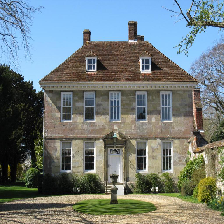

In [42]:
# 変換前の画像の表示
img_test

# 11_17: 画像の変換

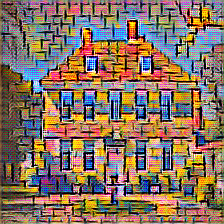

In [43]:
# モデルの適用
pred = model_gen.predict(img_arr_test)

# 変換後の画像の表示
img_pred = array_to_img(pred.squeeze())
img_pred